# SI 370 - Hypothesis testing (t-test and ANOVA)

Today's class will focus on two common statistical techniques used to investigate
hypotheses about the mean values within samples.  We'll spend most of our time 
focusing on ANOVA, as that seems to be scarier than the more familiar t-test.

We will be using two datasets: a simple on about pizza dough recipes and 
a more complex one drawn from a FiveThirtyEight example about biographical films.

We'll start by importing the usual suspects (including scipy, which we haven't used
much so far):

In [1]:
import numpy as np
import pandas as pd
import scipy

And we'll also import the main packages that we'll be using for our statistical analyses:

In [2]:
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Part I: Pizza Dough Recipes

https://dasl.datadescription.com/datafile/activating-baking-yeast/?_sfm_methods=Analysis+of+Variance&_sfm_cases=4+59943

To shorten the time it takes him to
make his favorite pizza, a student designed an experiment to
test the effect of sugar and milk on the activation times for
baking yeast. Specifically, he tested four different recipes and
measured how many seconds it took for the same amount of
dough to rise to the top of a bowl. He randomized the order
of the recipes and replicated each treatment 4 times.

### Q1: Go ahead and read in the data/activating-baking-yeast.txt file into a DataFrame called ```yeast```

In [4]:
yeast = pd.read_csv('data/activating-baking-yeast.txt',sep='\t')

### End Q1

As usual, inspect the DataFrame so we know what we're dealing with:

In [5]:
yeast.head()

,Activation Times,Recipe
0,575,A
1,395,A
2,280,B
3,120,B
4,720,C


In [6]:
yeast.columns

Index(['Activation Times', 'Recipe '], dtype='object')

Those column names aren't nice to work with, so let's go ahead and rename them
to ```activation``` and ```recipe```

In [7]:
to_be_renamed = {"Activation Times" :"activation", "Recipe ": "recipe"}
yeast = yeast.rename(columns = to_be_renamed)  

In [8]:
yeast.head()

,activation,recipe
0,575,A
1,395,A
2,280,B
3,120,B
4,720,C


Let's start by visually examining our data:

In [9]:
import seaborn as sns

### Q2: Create a boxplot the looks like the following:
![](resources/pizza-boxplot.png)

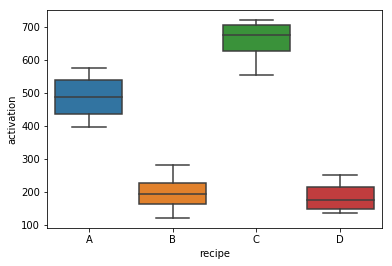

In [10]:
sns.boxplot("recipe",y="activation", data=yeast)

## Let's do an ANOVA!
We want to know if the above differences are statistically "real".  In other words, 
we want to know if the activation times vary according to the recipes.

We use statsmodels.forumula.api to create the model in a "readable" way.  For example, 
```activation ~ recipe``` would do that for us.  So we're going to create a model,
fit it to the data, and examine it.  We'll talk about the "Type 2" bit in class.

In [160]:
yeast_lm = ols('activation ~ recipe', data=yeast).fit()
table = sm.stats.anova_lm(yeast_lm, typ=2) # Type 2 ANOVA DataFrame
table

,sum_sq,df,F,PR(>F)
recipe,638967.6875,3.0,44.739175,8.639741e-07
Residual,57128.2500,12.0,NaN,NaN


### Q3: What does that tell us?

### End Q3

## Tukey's Honestly Significant Differences (HSD)

Ok, so we know there are significant differences between the different recipes, but
which one(s) are different from other ones?  To answer that, we can use Tukey's HSD (Honestly Sigificant Differences):

In [11]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

In [13]:
res2 = pairwise_tukeyhsd(yeast['activation'], yeast['recipe'])
res2.summary()

group1,group2,meandiff,lower,upper,reject
A,B,-290.0,-434.8661,-145.1339,True
A,C,169.75,24.8839,314.6161,True
A,D,-302.5,-447.3661,-157.6339,True
B,C,459.75,314.8839,604.6161,True
B,D,-12.5,-157.3661,132.3661,False
C,D,-472.25,-617.1161,-327.3839,True


### Q3: What does that mean?

### End Q3

For the next section, we draw our inspiration from the FiveThirtyEight article "‘Straight Outta Compton’ Is The Rare Biopic Not About White Dudes" (https://fivethirtyeight.com/features/straight-outta-compton-is-the-rare-biopic-not-about-white-dudes/).  FiveThiryEight has a great habit of publishing the data
that underpin their stories and those data are available via GitHub so it's easy to 
load them into a DataFrame:

In [14]:
biopics = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/biopics/biopics.csv", encoding="latin1")

In [15]:
biopics.head()

,title,site,country,year_release,box_office,director,number_of_subjects,subject,type_of_subject,race_known,subject_race,person_of_color,subject_sex,lead_actor_actress
0,10 Rillington Place,http://www.imdb.com/title/tt0066730/,UK,1971,-,Richard Fleischer,1,John Christie,Criminal,Unknown,NaN,0,Male,Richard Attenborough
1,12 Years a Slave,http://www.imdb.com/title/tt2024544/,US/UK,2013,$56.7M,Steve McQueen,1,Solomon Northup,Other,Known,African American,1,Male,Chiwetel Ejiofor
2,127 Hours,http://www.imdb.com/title/tt1542344/,US/UK,2010,$18.3M,Danny Boyle,1,Aron Ralston,Athlete,Unknown,NaN,0,Male,James Franco
3,1987,http://www.imdb.com/title/tt2833074/,Canada,2014,-,Ricardo Trogi,1,Ricardo Trogi,Other,Known,White,0,Male,Jean-Carl Boucher
4,20 Dates,http://www.imdb.com/title/tt0138987/,US,1998,$537K,Myles Berkowitz,1,Myles Berkowitz,Other,Unknown,NaN,0,Male,Myles Berkowitz


We're interested in the 'box_office' variable, which is an oddly-formatted representation of the box-office earnings for each movie.  We're going to create a function that 
converts representations like '$56.7M' to '56700000'.  How?

Time for some regular expressions (yay!):

In [16]:
import re

### Q4: Fill in the regular expression


In [17]:
def box_office_dollars(earnings):
    m = re.match(r'\$([0-9.]+)([KM]?)',earnings)
    if not m:
        return np.NaN
    ret = m.group(1)
    if not ret:
        return np.NaN
    try:
        ret = float(ret)
    except:
        return np.NaN
    if m.group(2) == 'M':
        return ret * 1000000
    if m.group(2) == 'K':
        return ret * 1000
    return ret

# Test out our function, which should print 537000.0 given $537K
box_office_dollars("$537K")


537000.0

### End Q4

Let's drop our missing values:

And apply it to our DataFrame, creating a new column called 'box_office_dollars'

In [19]:
biopics['box_office_dollars'] = biopics['box_office'].apply(box_office_dollars)

In [21]:
biopics = biopics.dropna()

As always, let's take a look at the distribution of our variable:


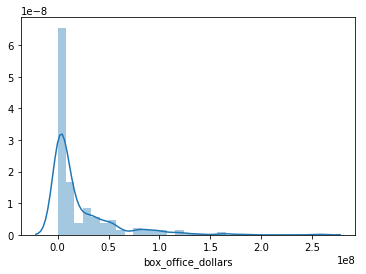

In [22]:
sns.distplot(biopics['box_office_dollars'])

Hmmmm.  That doesn't look good (why?) . 

Let's see if we can make that look a bit more like a normal distribution.  Let's 
apply a log transform:

In [23]:
biopics['log_box_office_dollars'] = np.log(biopics['box_office_dollars'])

In [24]:
biopics.head()

,title,site,country,year_release,box_office,director,number_of_subjects,subject,type_of_subject,race_known,subject_race,person_of_color,subject_sex,lead_actor_actress,box_office_dollars,log_box_office_dollars
1,12 Years a Slave,http://www.imdb.com/title/tt2024544/,US/UK,2013,$56.7M,Steve McQueen,1,Solomon Northup,Other,Known,African American,1,Male,Chiwetel Ejiofor,56700000.0,17.853285
5,21,http://www.imdb.com/title/tt0478087/,US,2008,$81.2M,Robert Luketic,1,Jeff Ma,Other,Known,Asian American,1,Male,Jim Sturgess,81200000.0,18.212426
6,24 Hour Party People,http://www.imdb.com/title/tt0274309/,UK,2002,$1.13M,Michael Winterbottom,1,Tony Wilson,Musician,Known,White,0,Male,Steve Coogan,1130000.0,13.937728
7,42,http://www.imdb.com/title/tt0453562/,US,2013,$95M,Brian Helgeland,1,Jackie Robinson,Athlete,Known,African American,1,Male,Chadwick Boseman,95000000.0,18.369387
12,A Dangerous Method,http://www.imdb.com/title/tt1571222/,Canada/UK,2011,$5.7M,David Cronenberg,3,Carl Gustav Jung,Academic,Known,White,0,Male,Michael Fassbender,5700000.0,15.555977


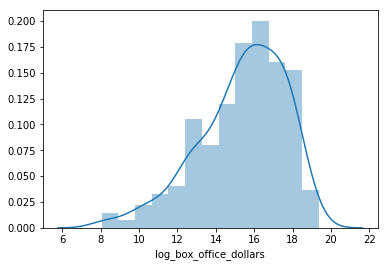

In [25]:
sns.distplot(biopics['log_box_office_dollars'])

Let's take a look at the (log) box_office_dollars according to whether
the subject of the biopic was a person of color or not:

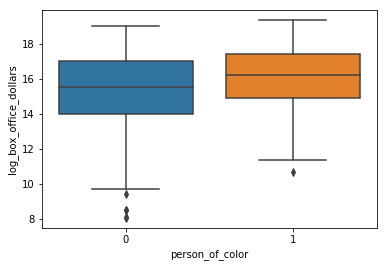

In [26]:
sns.boxplot("person_of_color",y="log_box_office_dollars",data=biopics)

### Q4: Does it look like there's a difference between the two groups?

### End Q4

## The t-test

To test of there's a statistically significant difference between two means, we
can use the independent sample t-test.  First, load up the right package:

In [27]:
from scipy.stats import ttest_ind

It's more readable if we split the data into two samples:

In [28]:
poc = biopics[biopics["person_of_color"] == 1]
not_poc = biopics[biopics["person_of_color" ] == 0]

In [29]:
ttest_ind(poc["log_box_office_dollars"],not_poc["log_box_office_dollars"])

Ttest_indResult(statistic=2.1155676498398988, pvalue=0.03516867248056494)


### Q5: What does that mean?

### End Q5

## ANOVA
Ok, that's pretty straight-forward.  Let's look at a more complex problem:

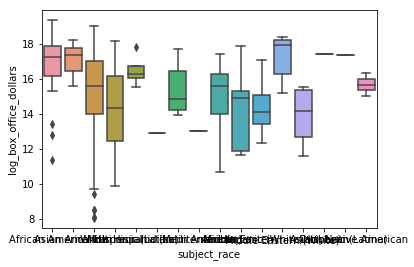

In [184]:
sns.boxplot("subject_race",y="log_box_office_dollars",data=biopics)

Without getting too worred about the fact that the axes are unreadable, it looks like
there are some differences between the different groups.  But are they real?

Let's start with an ANOVA:

In [30]:
box_office_dollars_lm = ols('log_box_office_dollars ~ subject_race', data=biopics).fit()
table = sm.stats.anova_lm(box_office_dollars_lm, typ=2) # Type 2 ANOVA DataFrame: no interaction effect
table

,sum_sq,df,F,PR(>F)
subject_race,182.134523,15.0,2.550334,0.001365
Residual,1428.318701,300.0,NaN,NaN


### Q6: Is there a statistically significant difference?

### End Q6

Let's apply Tukey's HSD using the same model and see what we get.

### Q7: Write code to use Tukey's HSD test on the subject_race variable and interpret the results.

In [191]:
res3 = pairwise_tukeyhsd(biopics['log_box_office_dollars'], biopics['subject_race'])
res3.summary()

group1,group2,meandiff,lower,upper,reject
African,African American,1.9884,-1.167,5.1437,False
African,Asian,-1.0387,-5.7648,3.6874,False
African,Asian American,2.1526,-3.0507,7.3558,False
African,Caribbean,2.517,-5.5439,10.5778,False
African,Hispanic (Latin American),0.4535,-3.2624,4.1694,False
African,Hispanic (Latina),2.4782,-5.5827,10.5391,False
African,Hispanic (Latino),1.5807,-3.1454,6.3068,False
African,Hispanic (White),-0.4918,-5.2179,4.2343,False
African,Indian,-2.0048,-10.0657,6.056,False
African,Mediterranean,-1.896,-9.9568,6.1649,False


Interpret your results

### End Q7

# <font color="green">END OF NOTEBOOK</font>
## Remember to submit HTML and IPYNB files via Canvas.